Here I Fine tuned Resnet18 model usinng our dataset .I trained it on only 5 epochs as colab have runtime limit. I was getting less number of missclassification here. I took reference from my previous internship code where i develped a classification model for retinal images.

Mounted at /content/drive
Blurry images: 1694
Sharp images: 2224
Training set: 3134 images
Test set: 784 images


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 81.9MB/s]


Epoch 1/5: Train Loss 0.3940, Train Acc 0.8296, Val Loss 0.5453, Val Acc 0.8214
Epoch 2/5: Train Loss 0.2983, Train Acc 0.8807, Val Loss 0.2750, Val Acc 0.8801
Epoch 3/5: Train Loss 0.2719, Train Acc 0.8848, Val Loss 0.2757, Val Acc 0.8916
Epoch 4/5: Train Loss 0.2710, Train Acc 0.8839, Val Loss 0.3481, Val Acc 0.8610
Epoch 5/5: Train Loss 0.2615, Train Acc 0.8909, Val Loss 0.3066, Val Acc 0.8929
Test Metrics: Accuracy 0.8929, Precision 0.9201, Recall 0.8300, F1 0.8727


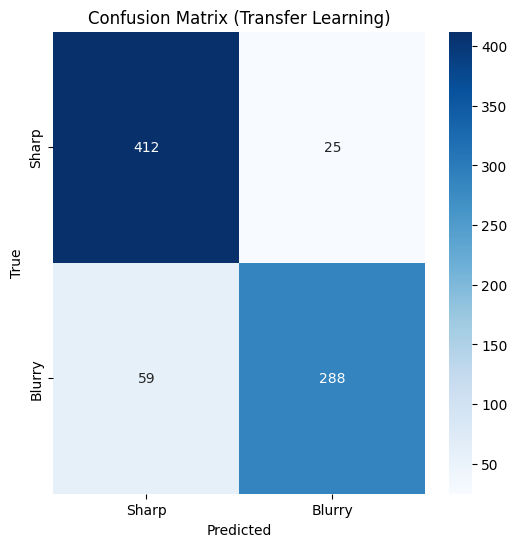

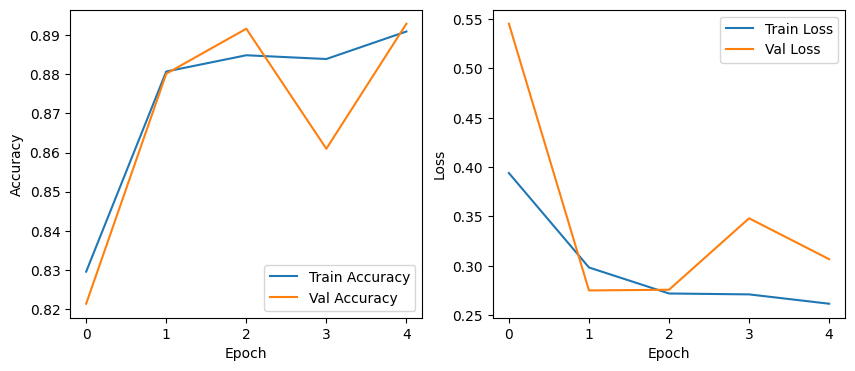

In [ ]:
from google.colab import drive
import os
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Set dataset and output paths
dataset_path = '/content/drive/MyDrive/blur_data'
blur_dir = os.path.join(dataset_path, 'blur')
sharp_dir = os.path.join(dataset_path, 'sharp')
output_dir = os.path.join(dataset_path, 'output')
os.makedirs(output_dir, exist_ok=True)

# Verify folders
if not os.path.exists(blur_dir) or not os.path.exists(sharp_dir):
    raise FileNotFoundError(f"Check folder paths: {blur_dir}, {sharp_dir}")

# Load dataset paths
image_paths = [(os.path.join(blur_dir, f), 1) for f in os.listdir(blur_dir) if f.endswith(('.jpg', '.png', '.jpeg'))] + \
              [(os.path.join(sharp_dir, f), 0) for f in os.listdir(sharp_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
print(f"Blurry images: {len([f for f in os.listdir(blur_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])}")
print(f"Sharp images: {len([f for f in os.listdir(sharp_dir) if f.endswith(('.jpg', '.png', '.jpeg'))])}")

# Split into train and test
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, [label for _, label in image_paths], test_size=0.2, random_state=42)
print(f"Training set: {len(train_paths)} images")
print(f"Test set: {len(test_paths)} images")

# Custom Dataset
class BlurDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = [p for p, _ in image_paths]
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return img, label

# Data transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Created datasets and dataloaders
train_dataset = BlurDataset(train_paths, train_labels, train_transform)
test_dataset = BlurDataset(test_paths, test_labels, test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load pre-trained ResNet18
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)  # doing binary classification
model = model.cuda() if torch.cuda.is_available() else model

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)   # since Adam supports momentum

# Training loop
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
train_losses, val_losses, train_accs, val_accs = [], [], [], []

for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        train_correct += (preds == labels).sum().item()
    train_loss /= len(train_loader)
    train_acc = train_correct / len(train_dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float()
            val_correct += (preds == labels).sum().item()
    val_loss /= len(test_loader)
    val_acc = val_correct / len(test_dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# Evaluate on test set
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).float()
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

# Compute metrics
accuracy = accuracy_score(test_labels, test_preds)
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)
print(f"Test Metrics: Accuracy {accuracy:.4f}, Precision {precision:.4f}, Recall {recall:.4f}, F1 {f1:.4f}")

# Save results
with open(os.path.join(output_dir, 'results_transfer.txt'), 'w') as f:
    f.write(f"Test Metrics: Accuracy {accuracy:.4f}, Precision {precision:.4f}, Recall {recall:.4f}, F1 {f1:.4f}\n")
    f.write(f"False Negatives (Blurry as Sharp): {sum((test_labels == 1) & (test_preds == 0))}\n")

# Confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Sharp', 'Blurry'], yticklabels=['Sharp', 'Blurry'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Transfer Learning)')
plt.savefig(os.path.join(output_dir, 'confusion_matrix_transfer.png'))
plt.show()

# Training history plot
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(output_dir, 'training_history.png'))
plt.show()